In [ ]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torchvision import transforms
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

In [ ]:
batch_size = 32
data_loader = torch.utils.data.DataLoader(MNIST('data', train=True, download=True, transform=transform),
                                          batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.59MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.95MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [ ]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [ ]:
writer = SummaryWriter()

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()
    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())

    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [ ]:
num_epochs = 3
n_critic = 5 # number of times the discriminator is trained for every single training step of the generator.
display_step = 50
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch), end=' ')
    for i, (images, labels) in enumerate(data_loader):

        step = epoch * len(data_loader) + i + 1 # step keeps track of the total number of training steps (batch updates) across all epochs.
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()

        d_loss = 0
        for _ in range(n_critic):
            d_loss = discriminator_train_step(len(real_images), discriminator,
                                              generator, d_optimizer, criterion,
                                              real_images, labels)


        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

        writer.add_scalars('scalars', {'g_loss': g_loss, 'd_loss': (d_loss / n_critic)}, step)

        if step % display_step == 0:
            generator.eval()#generator is set to evaluation mode
            z = Variable(torch.randn(9, 100)).cuda() #random noise vector z and corresponding labels are generated
            labels = Variable(torch.LongTensor(np.arange(9))).cuda()
            sample_images = generator(z, labels).unsqueeze(1) #generator produces sample images from the noise vector.
            grid = make_grid(sample_images, nrow=3, normalize=True) #images are arranged in a grid using make_grid and logged using writer.add_image
            writer.add_image('sample_image', grid, step)
    print('Done!')


Starting epoch 0... Done!
Starting epoch 1... Done!
Starting epoch 2... Done!


In [ ]:
torch.save(generator.state_dict(), 'generator_state.pt')

In [ ]:
# Generate random noise vectors for the generator input
z = Variable(torch.randn(100, 100)).cuda() # # 100 samples of 100-dimensional noise
# Create labels for conditional generation (10 classes, repeated 10 times each)
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).cuda()

In [ ]:
#  generator takes the noise z and the conditional labels labels
images = generator(z, labels).unsqueeze(1)
# produces a batch of synthetic images.
# The output shape of the generator is usually (batch_size, channels, height, width)

In [ ]:
grid = make_grid(images, nrow=10, normalize=True)

(-0.5, 301.5, 301.5, -0.5)

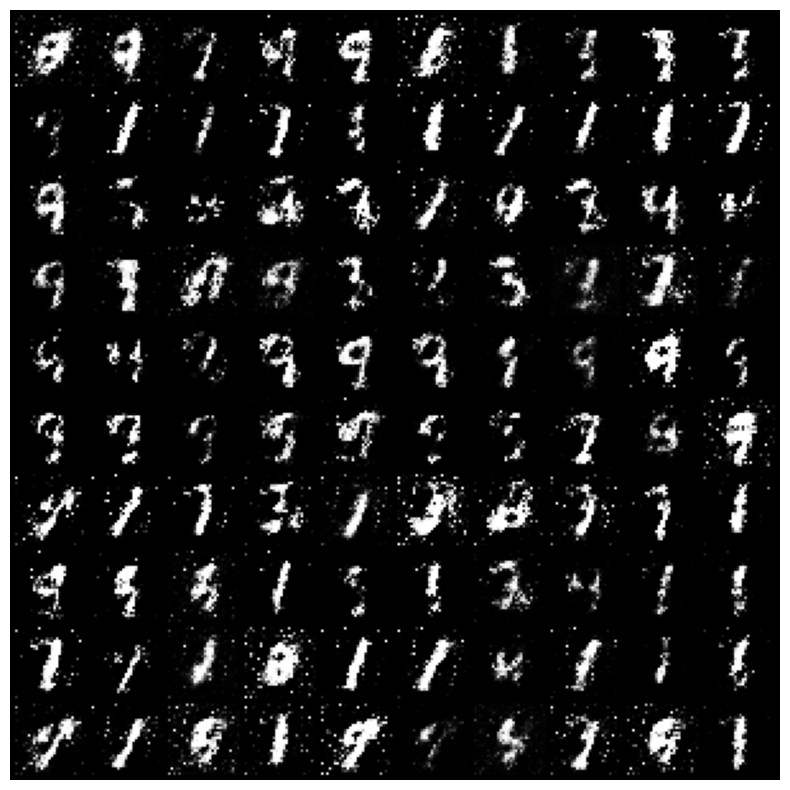

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).cpu().data, cmap='binary')
ax.axis('off')